Filtering criteria:

min.cells = 1000 per study
min.gene = 500
min.umi = 1000
max.MT = 30

# 1. Preprocess

In [2]:
library(Seurat)
library(DoubletFinder)
library(HGNChelper)
library(tidyverse)
library(here)

library(CelliD) # devtools::install_github("JiehoonKwak/CelliD")
library(harmony)
library(future)
source(here("notebooks/helper.R"))

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.4.1 but the current version is 4.4.2; it is recomended that you
reinstall ‘SeuratObject’ as the ABI for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current version is 1.7.1; it is recomended
that you reinstall ‘SeuratObject’ as the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Please cite our software :) 
 
 Sehyun Oh et al. HGNChelper: identification and correction of invalid gene symbols for human and mouse. F1000Research 2020, 9:1493. DOI: https://doi.org/10.12688/f1000research.28033.1 
 
 Type `citation('HGNChelper')` for a BibTeX entry.

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot

In [28]:
files <- list.files(here("data/tnl"), full.names = TRUE, recursive = TRUE, pattern = 'filtered_feature_bc_matrix', ignore.case = TRUE)
names(files) <- str_extract(files, "(?<=/tnl/)[^/]+")

In [29]:
objs <- list()
for (i in 1:length(files)){
    mat <- Read10X_h5(files[[i]])
    obj <- CreateSeuratObject(counts = mat, min.features = 500, min.cells = 5, project = names(files[i]))
    objs <- append(objs, list(obj))
}

In [30]:
for(i in 1:length(objs)){
    objs[[i]][["percent.MT"]]  <- PercentageFeatureSet(objs[[i]], pattern = "^MT-") 
    objs[[i]] <- subset(objs[[i]], subset = percent.MT < 30 & nCount_RNA > 1000)
}

In [31]:
objs <- lapply(objs, seuPreProcess)

Normalizing layer: counts



Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca_RNA_ to pcaRNA_”
Warning message:
“The following arguments are not used: force.recalc”
Warning message:
“The following arguments are not used: force.recalc”
Normalizing layer: counts

Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca_RNA_ to pcaRNA_”
Warning message:
“The following arguments are not used: force.recalc”
Warning message:
“The following arguments are not used: force.recalc”
Normalizing layer: counts

Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca_RNA_ to pcaRNA_”
Warning message:
“The following arguments are not used: force.recalc”
Warning message:
“The following arguments are not used: force.recalc”
Normalizing layer: 

In [9]:
# saveRDS(objs, here("data/tnl/tnl.rds"))

 ############################################
 ### DoubletFinder for dataset number  1 ###
 ############################################


Loading required package: fields

Loading required package: spam

Spam version 2.11-0 (2024-10-03) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: parallel



NULL
 ############################################
 ### DoubletFinder for dataset number  2 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send e

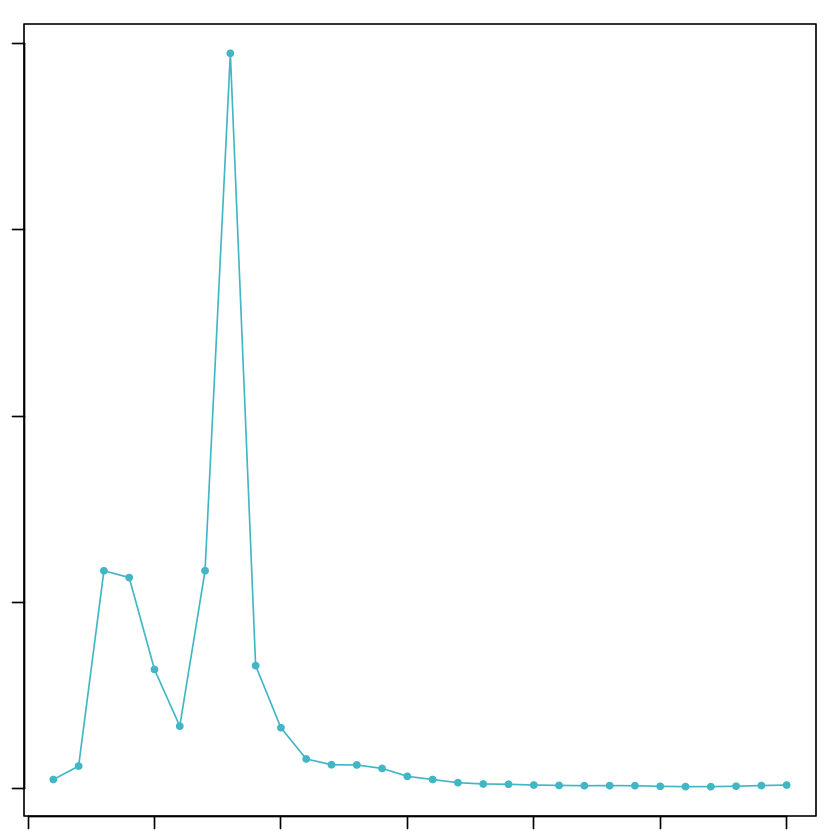

.."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Normalizing Seurat object..."
[1] "Creating Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Inte

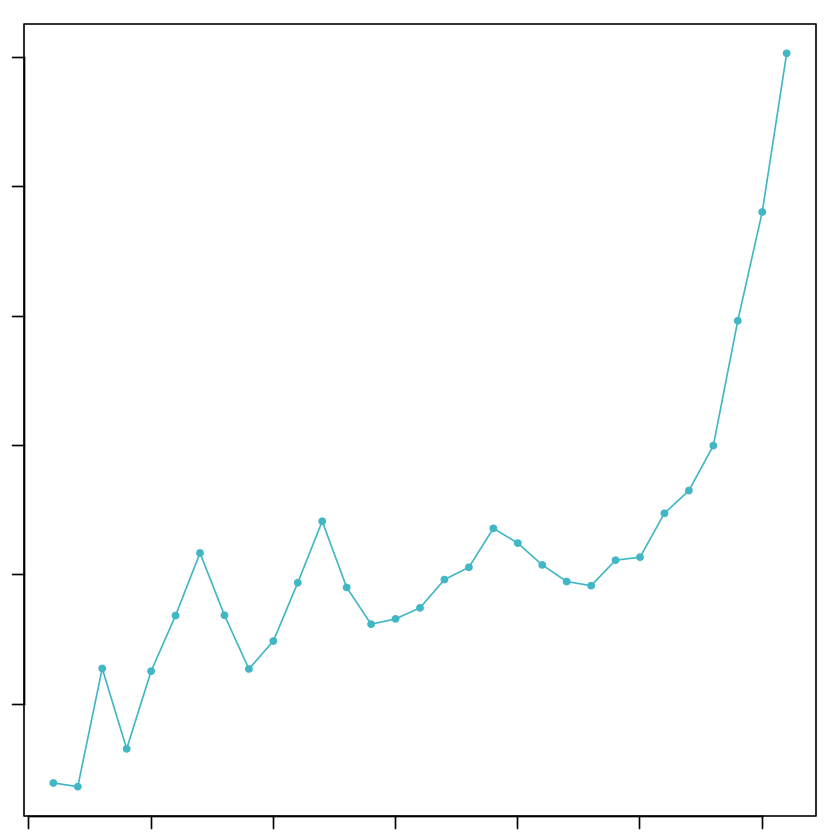

NULL
 ############################################
 ### DoubletFinder for dataset number  4 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat obje

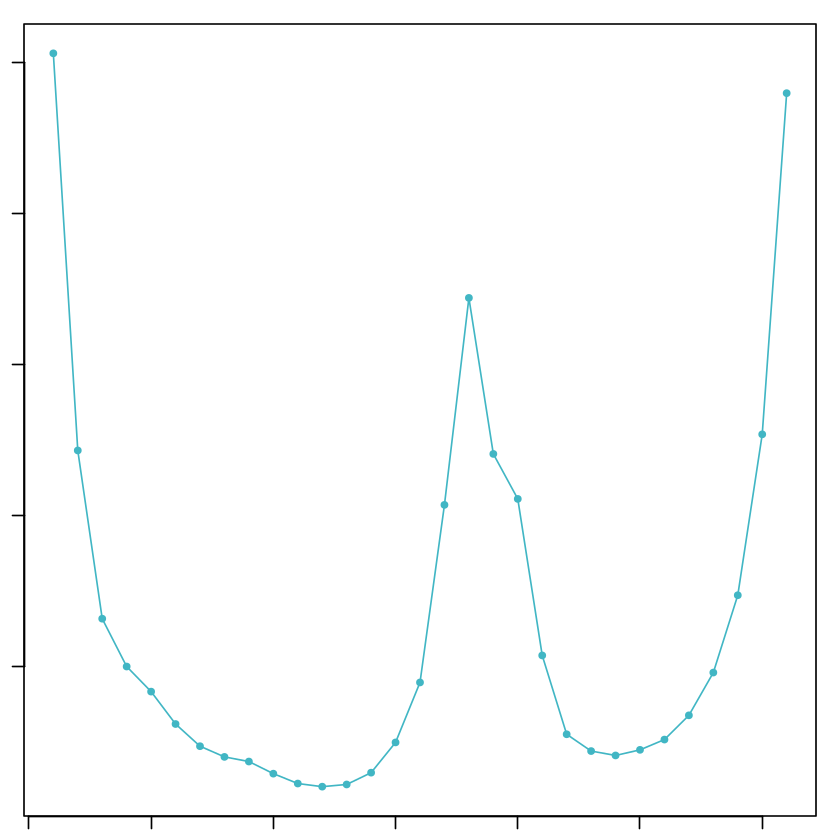

NULL
 ############################################
 ### DoubletFinder for dataset number  5 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Creating Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted syste

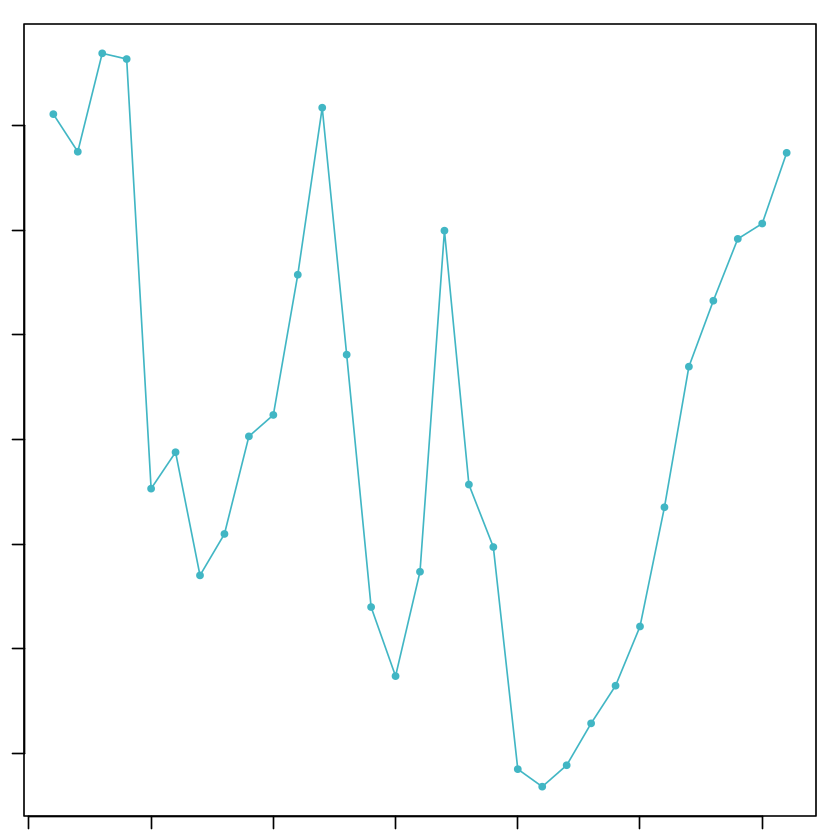

NULL
 ############################################
 ### DoubletFinder for dataset number  6 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Normalizing Seurat object..."
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 15%"
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Creating artificial doublets for pN = 20%"
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Creating artificial doublets for pN = 25%"
R_zmq_msg_send errno: 4 strerror: Inte

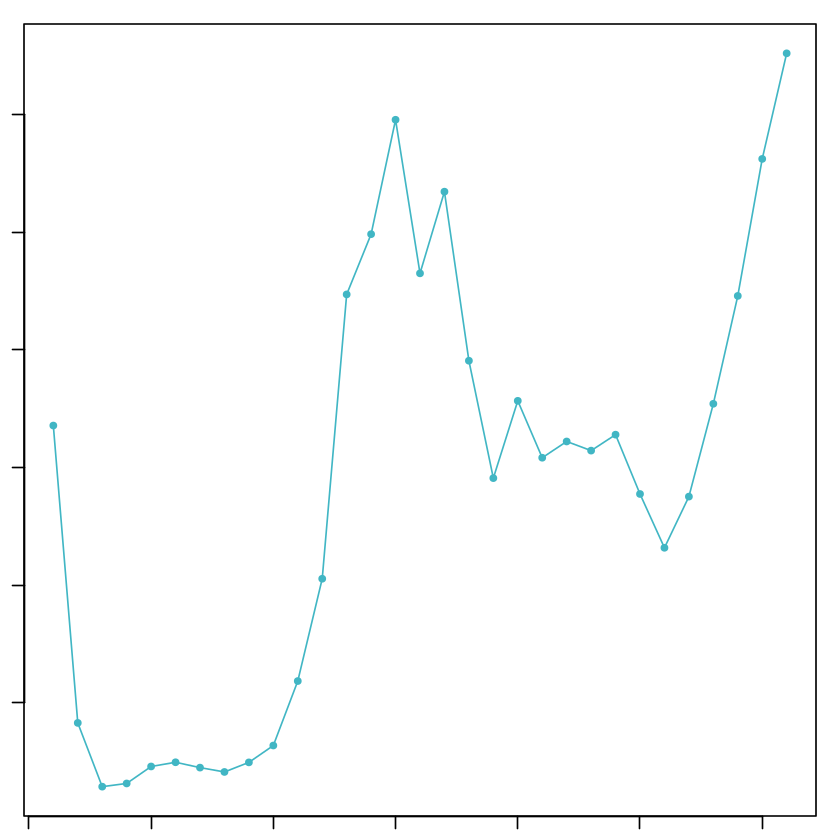

NULL
 ############################################
 ### DoubletFinder for dataset number  7 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Normalizing Seurat object..."
[1] "Creating Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted syste

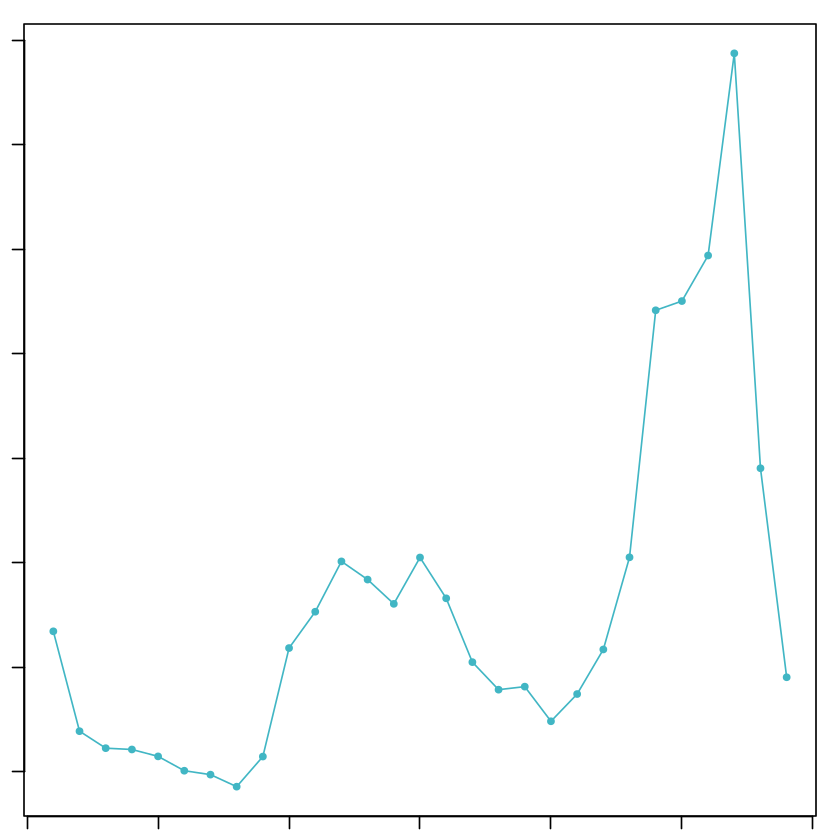

NULL
 ############################################
 ### DoubletFinder for dataset number  8 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Creating Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat obje

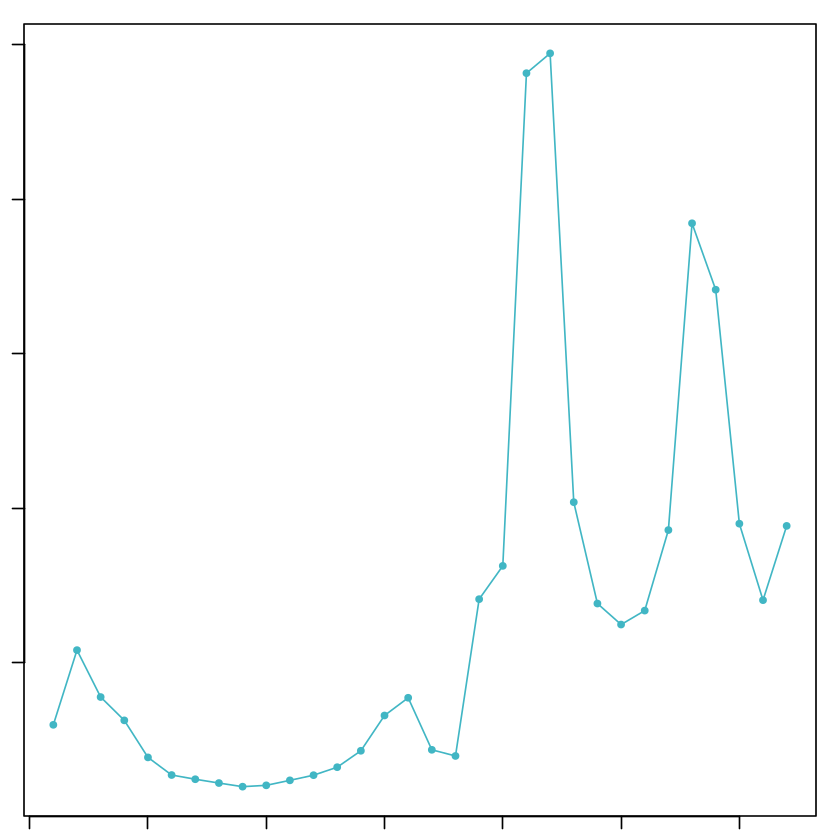

NULL
 ############################################
 ### DoubletFinder for dataset number  9 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Creating Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted syste

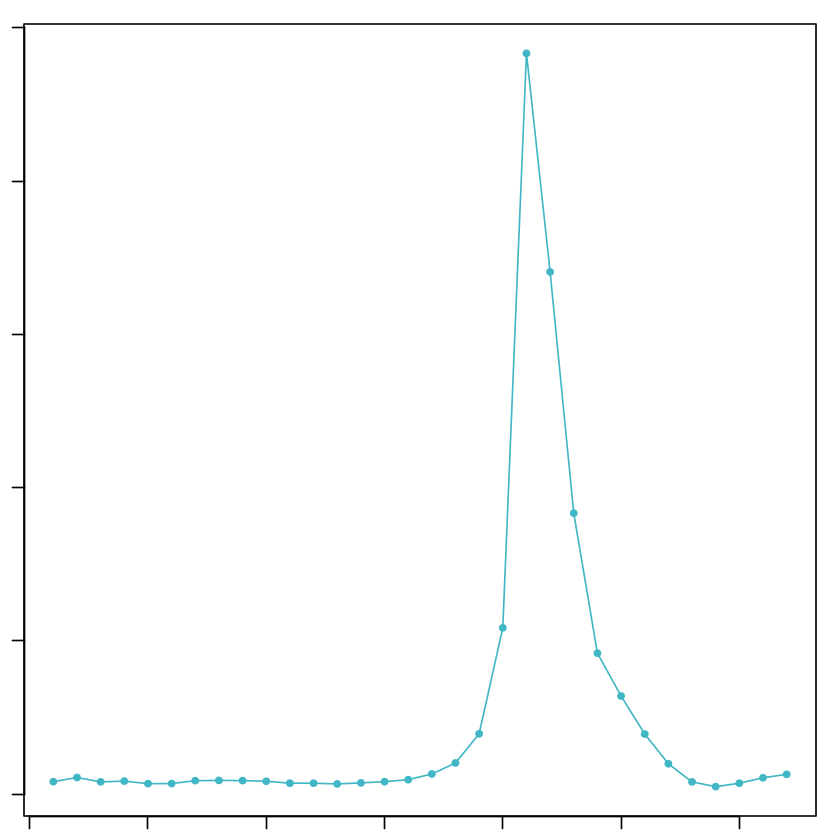

NULL
 ############################################
 ### DoubletFinder for dataset number  10 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat obj

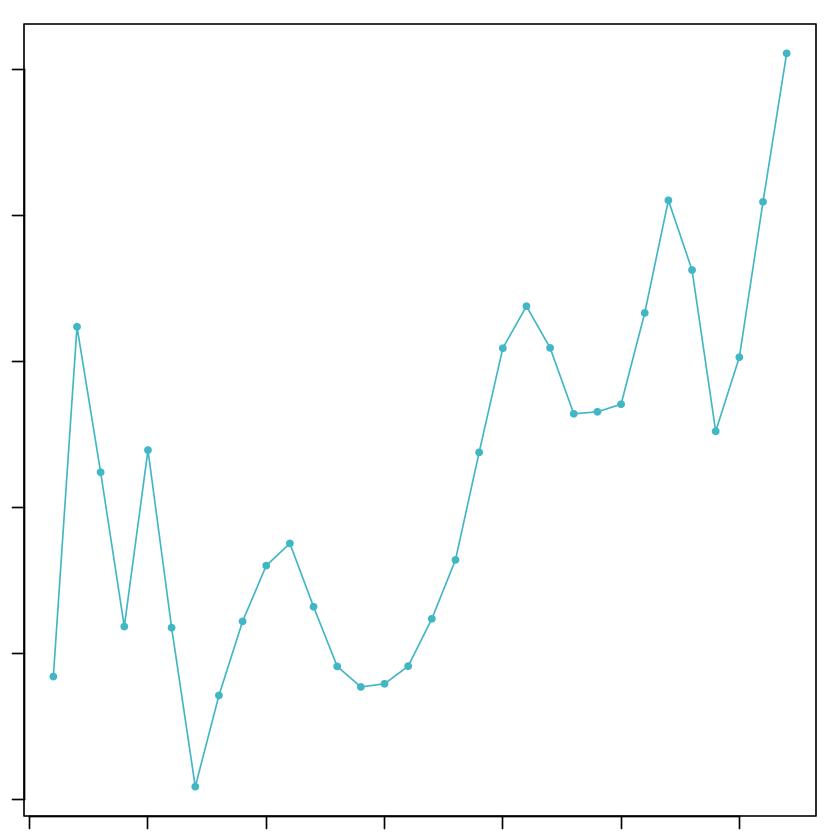

NULL
 ############################################
 ### DoubletFinder for dataset number  11 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Creating Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat obj

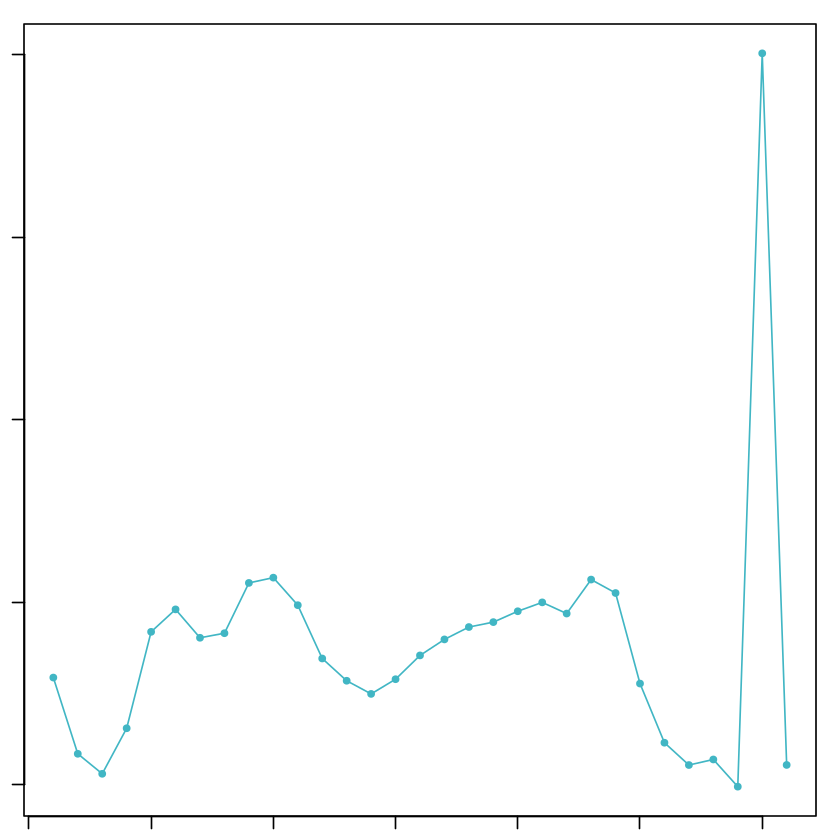

NULL
 ############################################
 ### DoubletFinder for dataset number  12 ###
 ############################################
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
[1] "Creating Seurat obj

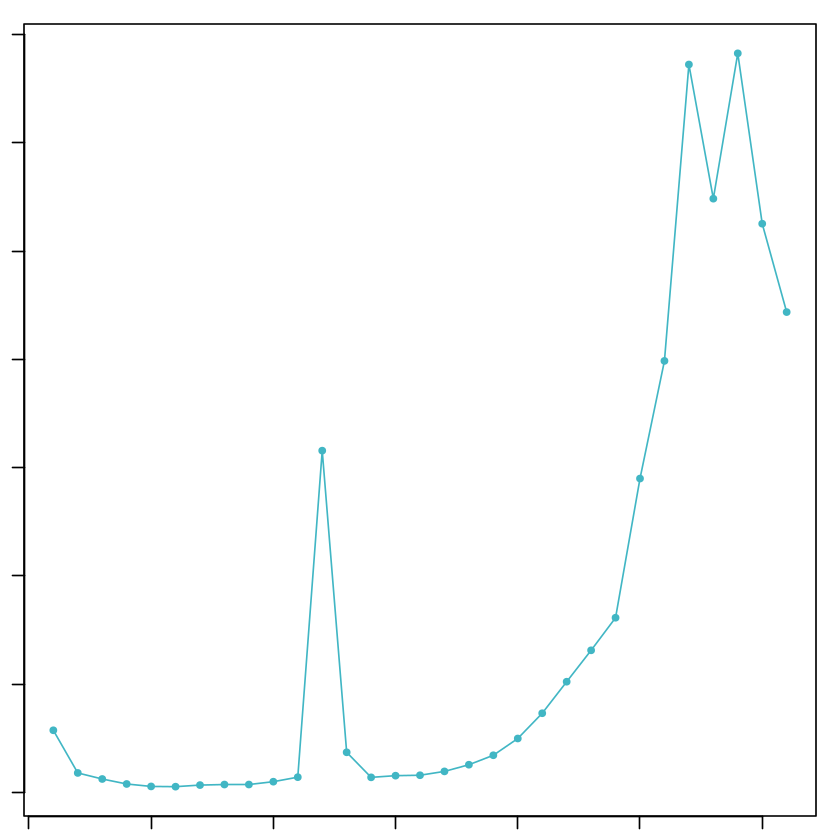

NULL


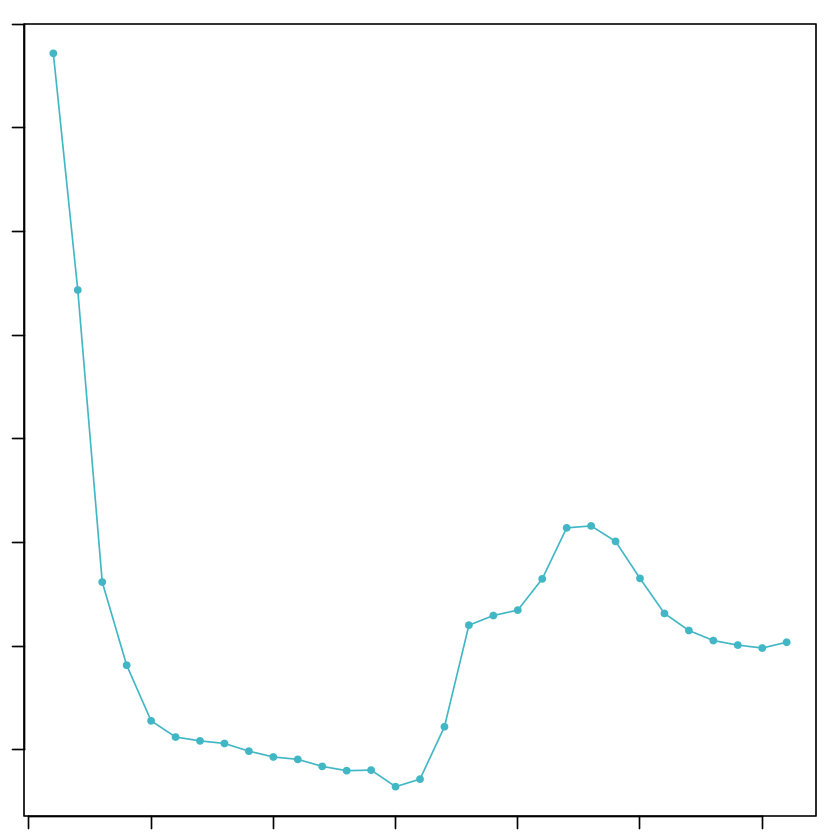

In [34]:
bcmvn <- list()
pK <- list()
homotypic.prop <- list()
nExp_poi <- list()
nExp_poi.adj <- list()

# Estimated Doublet Rate for each dataset
edr <- estimateDoubletRate.DWM(seur.list = objs)/100 #use your own known EDR here

for(i in 1:length(objs)){
  cat(' ############################################\n',
      '### DoubletFinder for dataset number ', i, '###\n',
      '############################################\n')
  
  ## pK Identification (no ground-truth)
  bcmvn[[i]]<- paramSweep(
    seu=objs[[i]],
    PCs = 1:objs[[i]]@reductions$umap_RNA@misc$n.pcs.used, 
    num.cores = 64
  ) %>% summarizeSweep(
    GT = FALSE
  ) %>% find.pK() 
  
  # Pull out max of bcmvn
  pK[[i]] <- as.numeric(as.character(bcmvn[[i]]$pK[bcmvn[[i]]$BCmetric==max(bcmvn[[i]]$BCmetric)]))
  
  ## Homotypic Doublet Proportion Estimate
  homotypic.prop[[i]] <- modelHomotypic(objs[[i]]$seurat_clusters) 
  
  nExp_poi[[i]] <- round(edr[[i]]*length(colnames(objs[[i]])))  
  nExp_poi.adj[[i]] <- round(nExp_poi[[i]]*(1-homotypic.prop[[i]]))
}

In [36]:
saveRDS(objs, here("data/tnl/tnl.rds"))

In [38]:
# Run DoubletFinder
for(i in 1:length(objs)){
  objs[[i]] <- 
    doubletFinder_V3.DWM_v2( # just changed it so the output metadata column name is customizable
      seu=objs[[i]], 
      PCs = 1:objs[[i]]@reductions$umap_RNA@misc$n.pcs.used,
      pN = 0.25, #default value
      pK= pK[[i]], 
      nExp = nExp_poi.adj[[i]],  
      reuse.pANN = F, 
      classification.name='DF.individual', 
      pANN.name='DF.pANN.individual'
    )
}

Creating  385  artificial doublets from  1156  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  1541  
   k =  123  
Classifying doublets...
Creating  2311  artificial doublets from  6933  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  9244  
   k =  2773  
Classifying doublets...
Creating  3012  artificial doublets from  9037  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  12049  
   k =  60  
Classifying doublets...
Creating  1287  artificial doublets from  3862  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  5149  
   k =  103  
Classifying doublets...
Creating  2383  artificial doublets from  7150  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  9533  
   k =  2860  
Classifying doublets...
Creating  210  artificial doublets from  631  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  841  
   k =  235  
Classifying doublets...
Creating  4001  artificial doublets from  12002  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  16003  
   k =  3201  
Classifying doublets...
Creating  4481  artificial doublets from  13442  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  17923  
   k =  3405  
Classifying doublets...
Creating  4445  artificial doublets from  13336  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  17781  
   k =  5334  
Classifying doublets...
Creating  950  artificial doublets from  2851  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  3801  
   k =  1102  
Classifying doublets...
Creating  2724  artificial doublets from  8173  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  10897  
   k =  3051  
Classifying doublets...
Creating  1311  artificial doublets from  3934  cells...
Creating Seurat object with artificial doublets...


Normalizing layer: counts



     Piping FindVariableFeatures(), ScaleData(), and RunPCA()...


Finding variable features for layer counts

Centering and scaling data matrix



Calculating PC distance matrix...
Computing pANN...
   nCells =  5245  
   k =  26  
Classifying doublets...


In [40]:
tnl <- merge(objs[[1]], y = unlist(objs[2:length(objs)]), add.cell.ids = names(files), project = "tnl", merge.data = T)

In [41]:
tnl

An object of class Seurat 
33020 features across 82507 samples within 1 assay 
Active assay: RNA (33020 features, 2000 variable features)
 36 layers present: counts.S1T, counts.S1V, counts.S2T, counts.S2V, counts.S3T, counts.S3V, counts.S4T, counts.S4V, counts.S5T, counts.S5V, counts.S6T, counts.S6V, data.S1T, scale.data.S1T, data.S1V, scale.data.S1V, data.S2T, scale.data.S2T, data.S2V, scale.data.S2V, data.S3T, scale.data.S3T, data.S3V, scale.data.S3V, data.S4T, scale.data.S4T, data.S4V, scale.data.S4V, data.S5T, scale.data.S5T, data.S5V, scale.data.S5V, data.S6T, scale.data.S6T, data.S6V, scale.data.S6V

In [42]:
tnl <- subset(tnl, subset = DF.individual == 'Singlet')

In [43]:
tnl

An object of class Seurat 
33020 features across 77064 samples within 1 assay 
Active assay: RNA (33020 features, 2000 variable features)
 36 layers present: counts.S1T, counts.S1V, counts.S2T, counts.S2V, counts.S3T, counts.S3V, counts.S4T, counts.S4V, counts.S5T, counts.S5V, counts.S6T, counts.S6V, data.S1T, scale.data.S1T, data.S1V, scale.data.S1V, data.S2T, scale.data.S2T, data.S2V, scale.data.S2V, data.S3T, scale.data.S3T, data.S3V, scale.data.S3V, data.S4T, scale.data.S4T, data.S4V, scale.data.S4V, data.S5T, scale.data.S5T, data.S5V, scale.data.S5V, data.S6T, scale.data.S6T, data.S6V, scale.data.S6V

In [45]:
gene.names <- checkGeneSymbols(rownames(tnl), unmapped.as.na=FALSE)

Maps last updated on: Sat Nov 16 10:35:32 2024

Warning message in checkGeneSymbols(rownames(tnl), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”


In [48]:
rownames(tnl) <- make.unique(gene.names$Suggested.Symbol)

In [52]:
tnl$author <- "tnl"
tnl$donor_id <- tnl$orig.ident
tnl$method <- "nuclei"
tnl$assay <- "10x 3' v3"

In [54]:
saveRDS(tnl, here("output/tnl.rds"))

# 2. CellID

In [3]:
obj <- readRDS(here("output/tnl.rds"))
obj

An object of class Seurat 
33020 features across 77064 samples within 1 assay 
Active assay: RNA (33020 features, 2000 variable features)
 36 layers present: counts.S1T, counts.S1V, counts.S2T, counts.S2V, counts.S3T, counts.S3V, counts.S4T, counts.S4V, counts.S5T, counts.S5V, counts.S6T, counts.S6V, data.S1T, scale.data.S1T, data.S1V, scale.data.S1V, data.S2T, scale.data.S2T, data.S2V, scale.data.S2V, data.S3T, scale.data.S3T, data.S3V, scale.data.S3V, data.S4T, scale.data.S4T, data.S4V, scale.data.S4V, data.S5T, scale.data.S5T, data.S5V, scale.data.S5V, data.S6T, scale.data.S6T, data.S6V, scale.data.S6V

In [4]:
obj <- JoinLayers(obj)

In [5]:
obj <- obj %>% NormalizeData(verbose = FALSE) %>% FindVariableFeatures(verbose = FALSE) %>% ScaleData(verbose = FALSE) %>% RunMCA(verbose = FALSE) %>% RunPCA(verbose = FALSE)

Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 19.0 GiB”
Computing Fuzzy Matrix



109.836 sec elapsed


Computing SVD



186.879 sec elapsed


Computing Coordinates



40.572 sec elapsed


In [7]:
obj <- RunHarmony(obj, group.by.vars = "donor_id", verbose = FALSE)

In [24]:
obj <- obj %>% RunUMAP(reduction = "harmony", dims = 1:30, verbose = FALSE) %>% FindNeighbors(reduction = "harmony", dims = 1:30, verbose = FALSE) %>% FindClusters(verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [9]:
signatures <- as.data.frame(readxl::read_excel(here('markers/gbmap.xlsx'), sheet = "S2"))
signatures <- signatures[-1:-2,] %>% `rownames<-` (NULL)
signatures.list <- list()
for(i in 1:length(colnames(signatures))){
  tmp <- list(na.omit(signatures[[i]]))
  signatures.list <- append(signatures.list, tmp)
}
names(signatures.list) <- colnames(signatures)

In [10]:
HGT_gbm_gs <- RunCellHGT(obj, pathways = signatures.list, dims = 1:50, n.features = 200)
gs_prediction <- rownames(HGT_gbm_gs)[apply(HGT_gbm_gs, 2, which.max)]
gs_prediction_signif <- ifelse(apply(HGT_gbm_gs, 2, max)>2, yes = gs_prediction, "unassigned")
obj$gs_prediction_main <- gs_prediction_signif


calculating distance




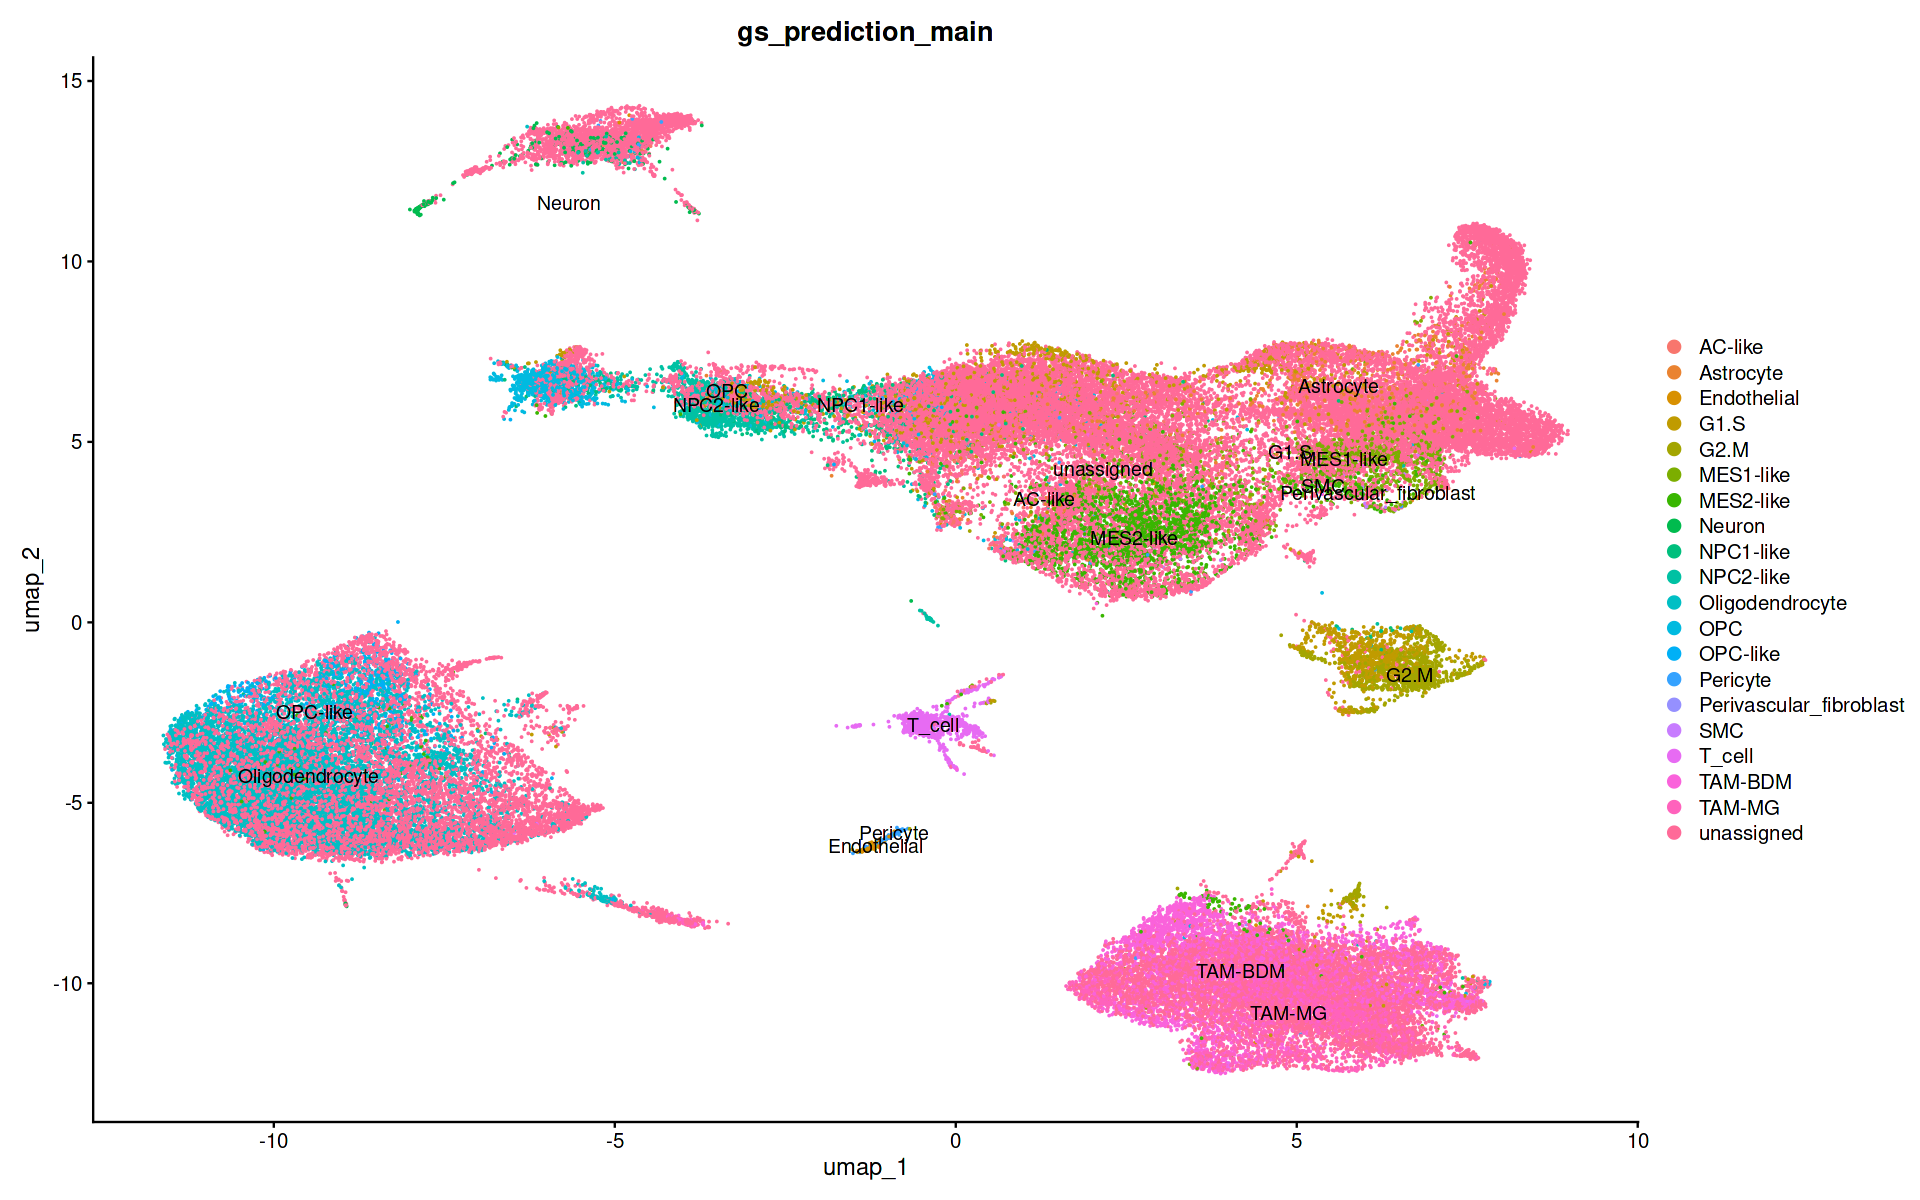

In [29]:
DimPlot(obj, group.by =  "gs_prediction_main", reduction = "umap", label = TRUE) 

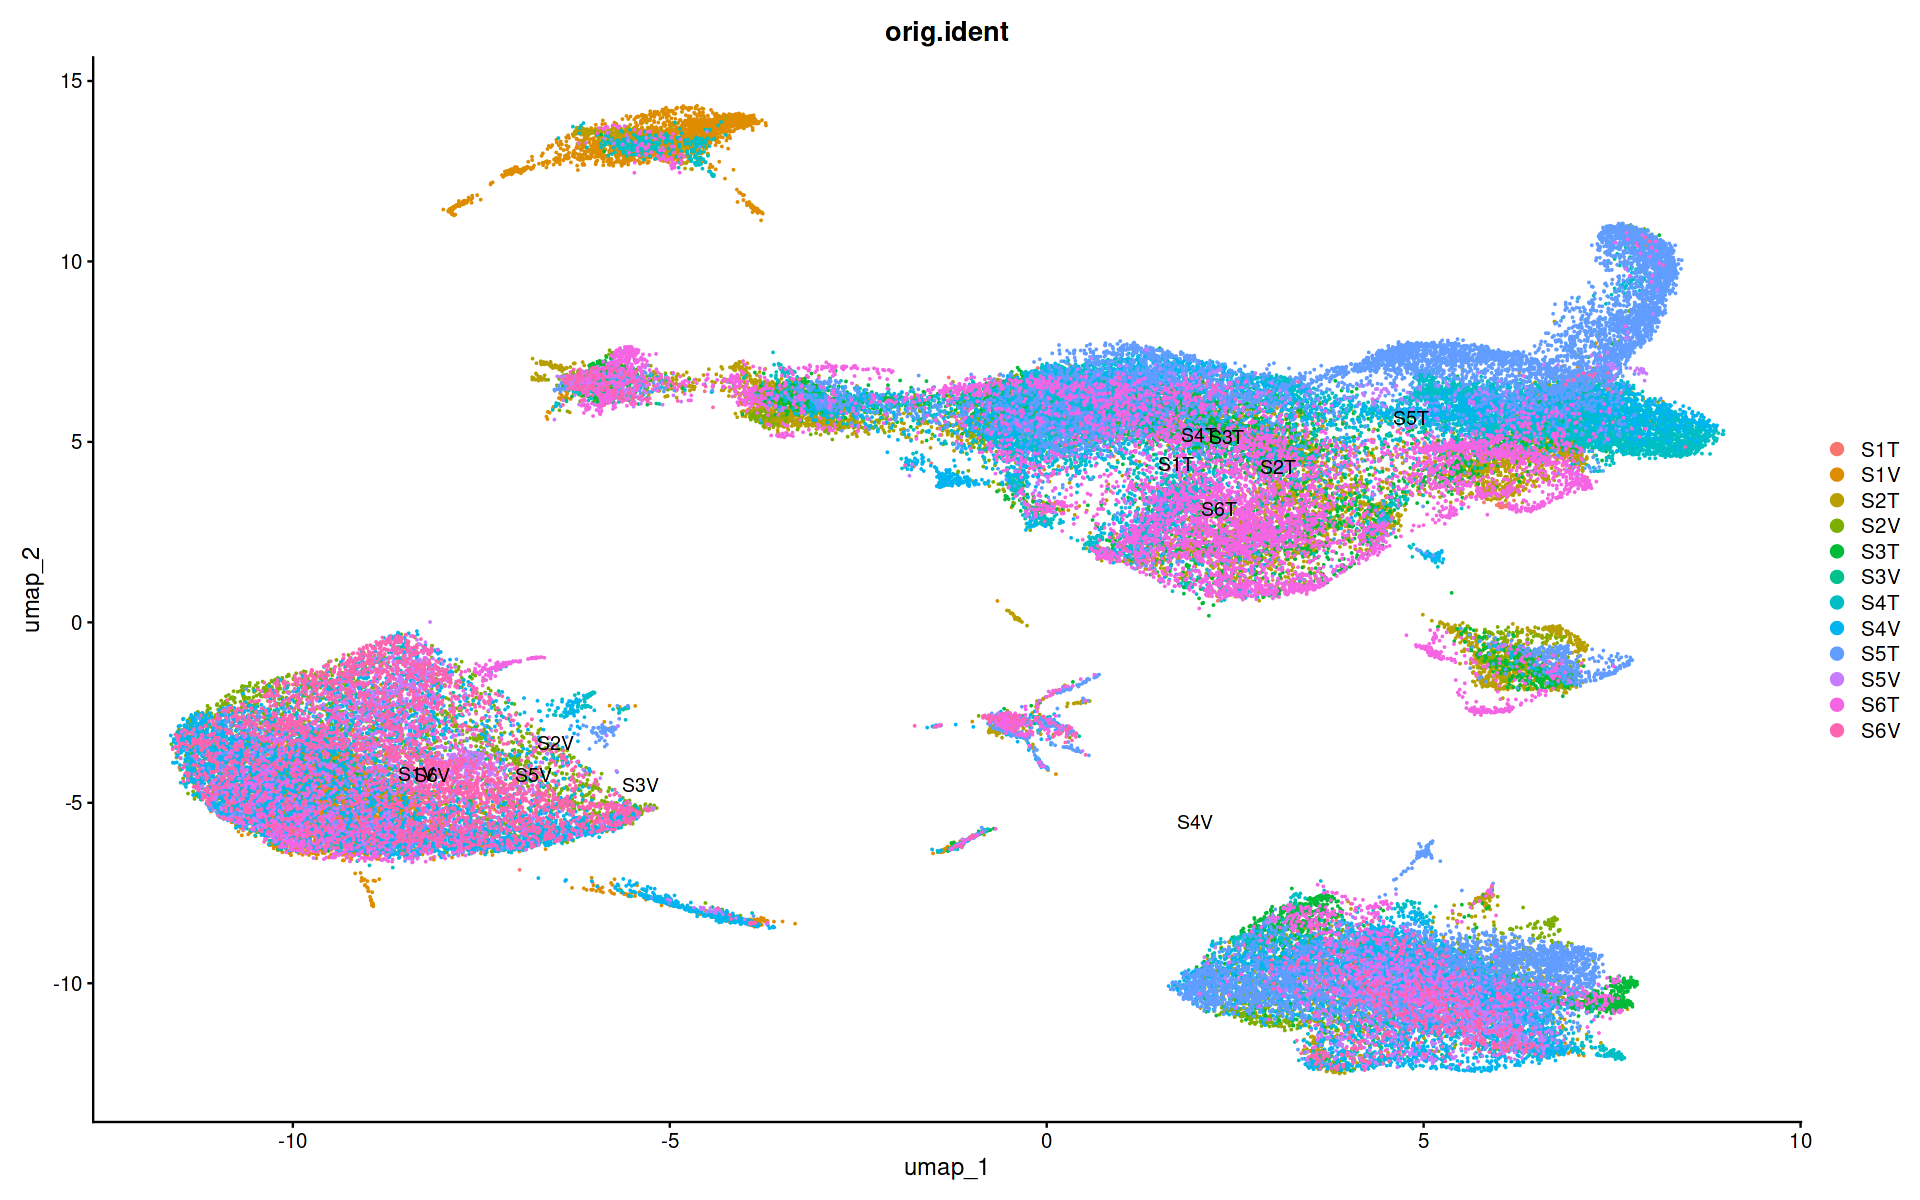

In [33]:
DimPlot(obj, group.by =  "orig.ident", reduction = "umap", label = TRUE) 

In [34]:
saveRDS(obj, here('output/tnl2.rds'))

# 3. Copykat & Annotation

In [36]:
obj[[]] |> head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.MT,RNA_snn_res.0.8,seurat_clusters,RNA_res.0.8,DF.individual,DF.pANN.individual,author,donor_id,method,assay,gs_prediction_main
,<chr>,<dbl>,<int>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
S1T_AAACCCAGTTCTTGCC-1,S1T,1193,899,0,1,1,1,Singlet,0.08130081,tnl,S1T,nuclei,10x 3' v3,unassigned
S1T_AAACGCTGTACTGTTG-1,S1T,1382,970,0,14,14,1,Singlet,0.04065041,tnl,S1T,nuclei,10x 3' v3,OPC
S1T_AAAGAACCATGTTCGA-1,S1T,1398,929,0,13,13,2,Singlet,0.07317073,tnl,S1T,nuclei,10x 3' v3,unassigned
S1T_AAAGAACTCTCATTTG-1,S1T,2778,1813,0,13,13,1,Singlet,0.11382114,tnl,S1T,nuclei,10x 3' v3,unassigned
S1T_AAAGGATCACTGTTCC-1,S1T,1075,789,0,2,2,4,Singlet,0.03252033,tnl,S1T,nuclei,10x 3' v3,unassigned
S1T_AAAGGATCAGGTCAAG-1,S1T,2544,1696,0,20,20,6,Singlet,0.13008130,tnl,S1T,nuclei,10x 3' v3,unassigned


In [ ]:
copykat <- read_csv(here('output/copykat_tnl.csv'))
obj <- AddMetadata(obj, copykat, col.name = "copykat")

In [ ]:

markers <- c('PTPRZ1', 'CD44', 'CD24', # malignant cells
             'MBP', 'MOBP', 'PLP1',# oligodendrocytes
             'GFAP', 'AQP4', # astrocytes
             'SYT1', # neurons
             'PTPRC', #immune cells
             'ITGA4', 'CD14', 'TGFBI','CD163', # BDM-like
             'P2RY12', 'CX3CR1', # MG-like
             'CD96', 'CD8A', 'IL7R', # T cells
             'VWF','FLT1', # endothelial 
             'DLC1', 'PDGFRB', 'PRKG1' # pericytes
            )